In [1]:
'''
Please upload data.sql file before executing.
file_path = '/content/data.sql'
Editor - Sameera Prasad
Date - 02/26/2026
Version - 1
Script to generate Revenue
Open in google colab.
'''

"\nPlease upload data.sql file before executing.\nfile_path = '/content/data.sql'\nEditor - Sameera Prasad\nDate - 02/26/2026\nVersion - 1\nScript to generate Revenue \n"

Reading file: /content/data.sql
Loaded 21 rows


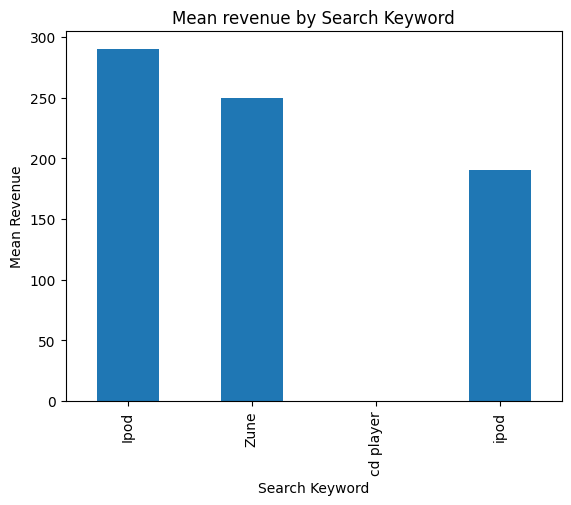


Results:
Search Engine Domain Search Keyword       date  Revenue
          google.com           Ipod 2009-09-27    290.0
            bing.com           Zune 2009-09-27    250.0
          google.com           ipod 2009-09-27    190.0
           yahoo.com      cd player 2009-09-27      0.0

Output written to: 2026-02-26_SearchKeyPerformance.tab


In [3]:
import pandas as pd
import re
from datetime import date, datetime
import matplotlib.pyplot as plt

# Maps each search engine domain to the query parameter that holds the keyword
DOMAIN_KEY_MAP = {
    'google.com': 'q',
    'yahoo.com':  'p',
    'bing.com':   'q',
}


class DataExtractor:
    def __init__(self, data: pd.DataFrame):
        # Initialize the DataExtractor with the dataframe
        self.data = data.fillna('')

    def extract_domain_and_keyword(self, referrer: str):
        """Pull the search engine domain and keyword out of a referrer URL."""
        try:
            match = re.search(r"(?<=://)(?:www\.)?([A-Za-z0-9\-\.]+\.[A-Za-z]{2,3})", referrer)
            if not match:
                return None, None

            domain = '.'.join(match.group(1).split('.')[-2:])

            # Use the global DOMAIN_KEY_MAP for search engine identification
            if domain not in DOMAIN_KEY_MAP:
                return None, None

            param = DOMAIN_KEY_MAP[domain]
            kw_match = re.search(param + r'=([^\&\/]+)', referrer)
            if not kw_match:
                return None, None

            keyword = kw_match.group(1).replace('+', ' ')
            return domain, keyword

        except Exception:
            return None, None

    def extract_revenue(self, row: dict):
        """Return revenue if this hit is a purchase event, otherwise 0."""
        if not row.get('product_list'):
            return 0.0

        fields = row['product_list'].split(';')
        if len(fields) < 4 or not fields[3]:
            return 0.0

        event_list = str(row.get('event_list', '')).replace('.0', '')
        if '1' not in event_list.split(','):
            return 0.0

        try:
            return float(fields[3])
        except ValueError:
            return 0.0

    def format_date(self, date_time: str):
        """Convert date string to YYYY-mm-dd format."""
        try:
            return datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
        except ValueError:
            return date_time


    def extract_revenue_data(self): # Changed to an instance method
        """
        Given a hit-level dataframe stored in self.data, return a dataframe of:
          Search Engine Domain | Search Keyword | Revenue | date
        """
        # `data = data.fillna('')` is now handled in __init__
        # `extractor = DataExtractor()` is no longer needed, use `self` instead

        # Pass 1: find the first search engine referrer for each IP
        session_referrers = {}  # ip -> (domain, keyword)
        for _, row in self.data.iterrows(): # Use self.data
            ip = row['ip']
            if ip in session_referrers:
                continue
            domain, keyword = self.extract_domain_and_keyword(row['referrer']) # Call instance method
            if domain and keyword:
                session_referrers[ip] = (domain, keyword)

        # Pass 2: find purchase rows and attribute revenue to the session referrer
        results = []
        dates = set()

        for _, row in self.data.iterrows(): # Use self.data
            revenue = self.extract_revenue(row) # Call instance method
            # if revenue == 0.0:
            #     continue

            ip = row['ip']
            if ip not in session_referrers:
                continue

            domain, keyword = session_referrers[ip]
            date_str = self.format_date(row['date_time']) # Call instance method
            dates.add(date_str)

            results.append({
                'Search Engine Domain': domain,
                'Search Keyword':       keyword,
                'Revenue':              revenue,
                'date':                 date_str,
            })

        df = pd.DataFrame(results, columns=['Search Engine Domain', 'Search Keyword', 'Revenue', 'date'])

        # Group by domain + keyword and sum revenue
        df = (
            df.groupby(['Search Engine Domain', 'Search Keyword', 'date'], as_index=False)
              .agg({'Revenue': 'sum'})
              .sort_values('Revenue', ascending=False)
              .reset_index(drop=True)
        )

        filtered_df = df.groupby(df['Search Keyword'])['Revenue'].mean()
        filtered_df.plot(kind='bar')
        plt.title('Mean revenue by Search Keyword')
        plt.xlabel('Search Keyword')
        plt.ylabel('Mean Revenue')
        plt.show()


        return df, dates


def main(file_path: str):
    # Step 1: Read the .sql file (tab-separated)
    print(f"Reading file: {file_path}")
    data = pd.read_csv(file_path, sep='\t', encoding='utf-8-sig')
    print(f"Loaded {len(data)} rows")

    # Step 2: Process it
    ex = DataExtractor(data) # Instantiate DataExtractor with data
    df, dates = ex.extract_revenue_data() # Call extract_revenue_data on the instance without passing data

    # Step 3: Print results to console
    print("\nResults:")
    print(df.to_string(index=False))

    # Step 4: Write output file
    output_file = f"{date.today().strftime('%Y-%m-%d')}_SearchKeyPerformance.tab"

    df.to_csv(output_file, sep='\t', index=False)
    print(f"\nOutput written to: {output_file}")


if __name__ == "__main__":
    main("/content/data.sql")